## Import data of COVID-19 cases (updated 3x/day)

In [19]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mtplt
from matplotlib.ticker import MaxNLocator

# libraries to try to change the x axis range (not working yet)
import datetime
import matplotlib.dates as mdates
import numpy as np

mtplt.rcParams.update({'font.size': 14})
figsize = (10,6)

outputFolder = 'Results/COVID19/'
transparent = False

a = ['Italy', 'Spain', 'Germany', 'France', 'United Kingdom', 'US', 'Brazil', 'Korea, South', 'China']
N = 30 #days to look back

In [20]:
data = pd.read_json("https://pomber.github.io/covid19/timeseries.json")

In [21]:
countries = data.keys() # get the names of all countries

In [22]:
# all countries in the same DataFrame
country = pd.DataFrame()
for c in countries:
    date = [d.get("date") for d in data[c]]
    confirmed = [d.get("confirmed") for d in data[c]]
    deaths = [d.get("deaths") for d in data[c]]
    recovered = [d.get("recovered") for d in data[c]] 
    newCountry = pd.DataFrame({'date':date, 'confirmed':confirmed, 'deaths':deaths, 'recovered':recovered}).assign(country=c)
    country = country.append(newCountry)

## Compare active cases/million people per country

In [23]:
# Add active cases
country['active'] = country.confirmed-country.deaths-country.recovered

In [24]:
# import population of different countries
data_population = pd.read_csv('Data/demographic-2019-csv-1.csv', delimiter = ',', skiprows=1, encoding='latin-1',
                         names = ['Initials', 'Country', "Pop_1969","Pop_1994","Pop_2019","Total fertility rate, per woman, 1969","Total fertility rate, per woman, 1994","Total fertility rate, per woman, 2019","Average annual rate of population change, percent, 2010-2019","Population aged  0-14, percent, 2019","Population aged 10-24, percent, 2019","Population aged 15-64, percent, 2019","Population aged 65 and older, percent, 2019","Life expectancy at birth, years, 1969","Life expectancy at birth, years, 1994","Life expectancy at birth, years, 2019"])

In [25]:
# Correct data
data_population.loc[data_population['Initials']=='US', 'Country'] = 'US'

In [26]:
population = data_population[['Country','Pop_2019']]
country = country.merge(data_population[['Country','Pop_2019']], how = 'left', left_on = 'country',
         right_on = 'Country').fillna(100000)
country = country.drop('Country', 1)

In [27]:
# change data type of the population to a number
country['Pop_2019'] = pd.to_numeric(country['Pop_2019'], errors='coerce').fillna(100000)
#country.loc[country['Country'=='US'], 'Pop_2019'] = country.loc[country['Country'=='US'], 'Pop_2019']/1000

In [28]:
country['active_per_million'] = country.active/(country.Pop_2019)

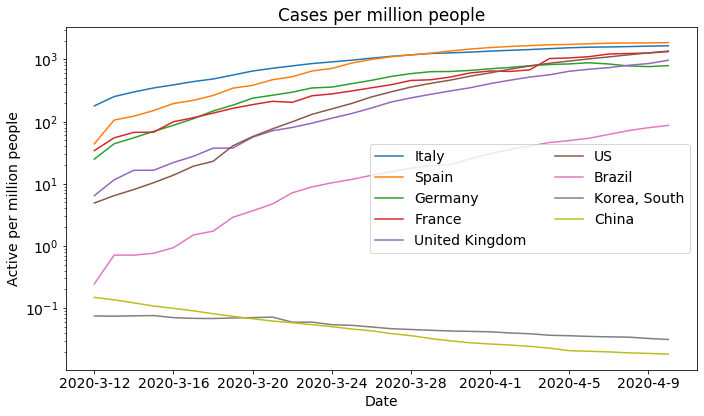

In [29]:
plt.figure(figsize = figsize)

for c in a:
    plt.plot(country[country.country == c].date.tail(N), country[country.country == c].active_per_million.tail(N))

ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('Active per million people')
ax.set_title('Cases per million people')

ax.set_yscale('log')
locator = MaxNLocator(nbins=9) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locator)
#ax.yaxis.set_major_locator(MaxNLocator( integer=True))
plt.legend(a, ncol=2)

plt.tight_layout()
plt.savefig(outputFolder + 'CasesPerMillionPeople.png', dpi=250, transparent=transparent)

## Cases per Hospital Bed
data from: https://data.oecd.org/healtheqt/hospital-beds.htm

In [30]:
# import population of different countries
data_population = pd.read_csv('Data/Hospital_Beds.csv', delimiter = ',', skiprows=1, encoding='latin-1',
                         names = ["LOCATION","INDICATOR","SUBJECT","MEASURE","FREQUENCY","TIME","Value","Flag Codes"])

In [31]:
# Todo: Remove the older data
# Join both databases

## \% change in active cases

In [32]:
country['active_per_cent'] = country.active.pct_change().fillna(value=0)*100

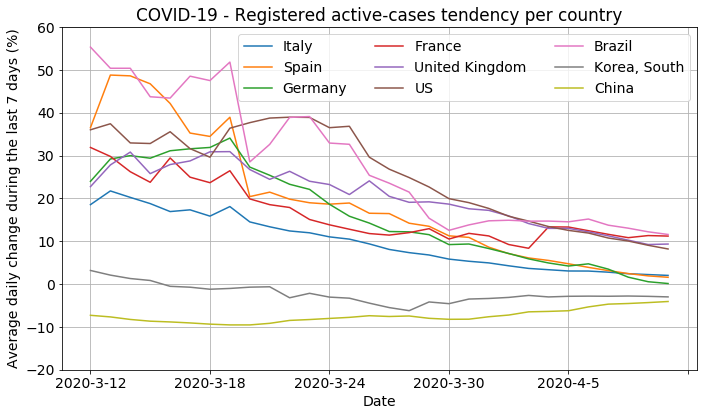

In [33]:
plt.figure(figsize = figsize)

for c in a:
    plt.plot(country[country.country == c].date.tail(N), country[country.country == c].active_per_cent.rolling(window=7).mean().tail(N))

ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('Average daily change during the last 7 days (%)')
ax.set_title('COVID-19 - Registered active-cases tendency per country')

locator = MaxNLocator(nbins=6) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locator)
ax.set_ylim(bottom = -20, top = 60)
#ax.yaxis.set_major_locator(MaxNLocator( integer=True))
plt.legend(a, ncol= 3)
plt.grid(True)

plt.tight_layout()
plt.savefig(outputFolder + 'CasesPerMillionPeople.png', dpi=250, transparent=transparent)

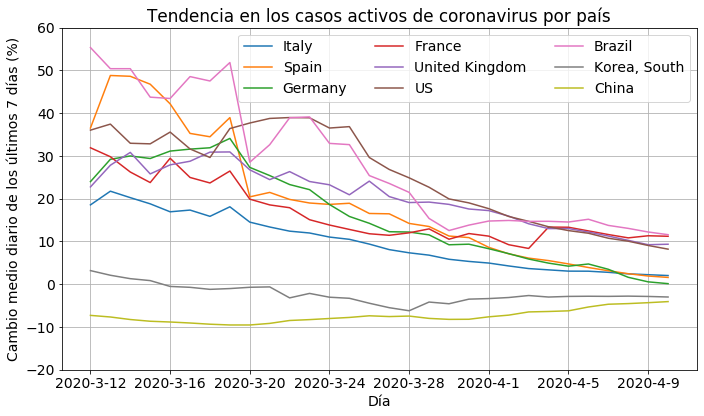

In [34]:
plt.figure(figsize = figsize)

for c in a:
    plt.plot(country[country.country == c].date.tail(N), country[country.country == c].active_per_cent.rolling(window=7).mean().tail(N))

ax = plt.gca()
ax.set_xlabel('Día')
ax.set_ylabel('Cambio medio diario de los últimos 7 días (%)')
ax.set_title('Tendencia en los casos activos de coronavirus por país')

locator = MaxNLocator(nbins=8) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locator)
ax.set_ylim(bottom = -20, top = 60)
#ax.yaxis.set_major_locator(MaxNLocator( integer=True))
plt.legend(a, ncol=3)
plt.grid(True)

plt.tight_layout()
plt.savefig(outputFolder + 'CasesPerMillionPeople.png', dpi=250, transparent=transparent)

## Cases per critical care bed

data from: https://www.statista.com/chart/21105/number-of-critical-care-beds-per-100000-inhabitants/

In [16]:
data_careBeds = pd.read_csv('Data/CriticalCareBeds2012.csv', delimiter = ',', skiprows=1, encoding='latin-1',
                         names = ["country", "critical_care_beds"])

In [17]:
country = country.merge(data_careBeds, how = 'left', left_on = 'country',
         right_on = 'country')

In [18]:
country['active_per_criticalCareBed'] = country.active/(country.Pop_2019*10*country['critical_care_beds'])

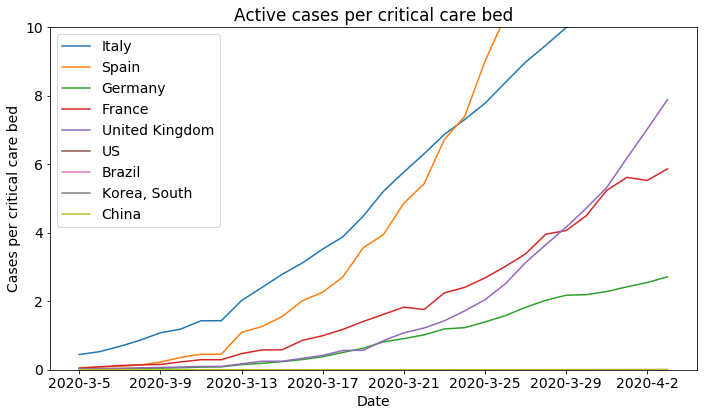

In [19]:
plt.figure(figsize = figsize)

for c in a:
    plt.plot(country[country.country == c].date.tail(N), country[country.country == c].active_per_criticalCareBed.tail(N))

ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('Cases per critical care bed')
ax.set_title('Active cases per critical care bed')
#plt.set_xlim(left = datetime.datetime(2020,2,20)) # not working
ax.set_ylim(bottom = 0, top = 10)

#ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m")) # not working

#ax.set_yscale('log')
locator = MaxNLocator(nbins=9) # Number of xticks - 1
ax.xaxis.set_major_locator(locator)
#ax.yaxis.set_major_locator(MaxNLocator( integer=True)) #not working
plt.legend(a)

plt.tight_layout()
plt.savefig(outputFolder + 'ActiveCasesPerCCBed.png', dpi=250, transparent=transparent)

### Assuming 70 % of these beds are used for other purposes, only a 30% is available

todo: find real data for each country

In [20]:
country['active_per_criticalCareBed_available'] = country.active/(country.Pop_2019*10*country['critical_care_beds']*0.3)

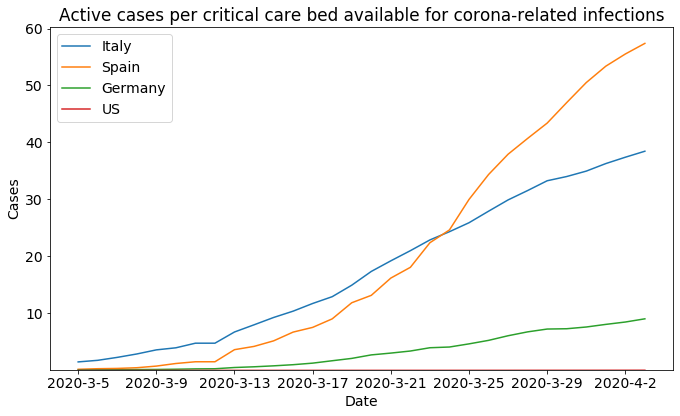

In [21]:
a = ['Italy', 'Spain', 'Germany', 'US']

plt.figure(figsize = figsize)

for c in a:
    plt.plot(country[country.country == c].date.tail(N), country[country.country == c].active_per_criticalCareBed_available.tail(N))

ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.set_title('Active cases per critical care bed available for corona-related infections')
#plt.set_xlim(left = datetime.datetime(2020,2,20)) # not working
ax.set_ylim(bottom = 0.1)

#ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m")) # not working

#ax.set_yscale('log')
locator = MaxNLocator(nbins=9) # Number of xticks - 1
ax.xaxis.set_major_locator(locator)
#ax.yaxis.set_major_locator(MaxNLocator( integer=True)) #not working
plt.legend(a)

plt.tight_layout()
plt.savefig(outputFolder + 'CasesPerCCBed_Corona.png', dpi=250, transparent=transparent)

### Assuming a 10% of the cases need an intensive care bed at the same moment

from: https://www.independent.co.uk/news/health/coronavirus-italy-doctors-intensive-care-deaths-a9384356.html

If this number gets higher than 1, then the medical system begins to collapse and the death rate will dramatically increase

In case less than 10% of the cases need intensive care and have enough with a ventilator, then this rate might notably change

In [22]:
country['active_per_criticalCareBed_available_needed'] = country.active*0.1/(country.Pop_2019*10*country['critical_care_beds']*0.3)

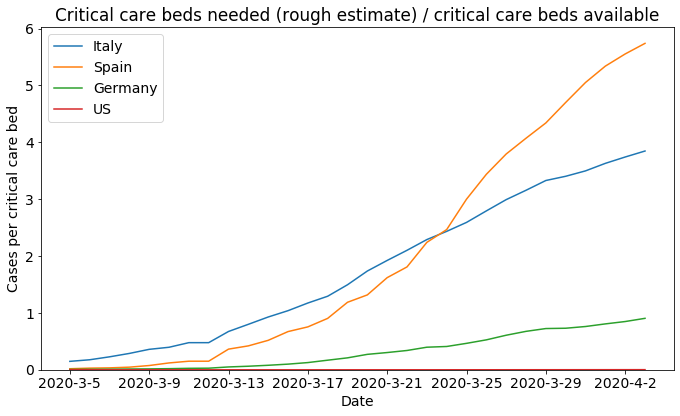

In [23]:
a = ['Italy', 'Spain', 'Germany', 'US']

plt.figure(figsize = figsize)

for c in a:
    plt.plot(country[country.country == c].date.tail(N), country[country.country == c].active_per_criticalCareBed_available_needed.tail(N))

ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('Cases per critical care bed')
ax.set_title('Critical care beds needed (rough estimate) / critical care beds available')
#ax.set_xlim(left = xmin, right = xmin) # not working
ax.set_ylim(bottom = 0)

#ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m")) # not working

#ax.set_yscale('log')
locator = MaxNLocator(nbins=9) # Number of xticks - 1
ax.xaxis.set_major_locator(locator)
#ax.yaxis.set_major_locator(MaxNLocator( integer=True)) #not working
plt.legend(a)

plt.tight_layout()
plt.savefig(outputFolder + 'CasesPerCCB_Corona_Needed.png', dpi=250, transparent=transparent)